In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
np.random.seed(0)


In [2]:
data1_path = 'data/telco/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data2_path = 'data/adult/adult.data'
data2_extra = 'data/adult/adult.test'
data3_path = 'data/creditcardfraud/creditcard.csv'

In [3]:
def preprocess_dataset1(data1_path):
    df = pd.read_csv(data1_path)
    df = df.drop('customerID', axis=1)
    X, y = df.drop('Churn', axis=1), df['Churn']
    X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
    
    my_cols = categorical_cols + numerical_cols
    X_train = X_train[my_cols].copy()
    X_test = X_test[my_cols].copy()
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed)
    bias_train = pd.DataFrame(np.ones((X_train_preprocessed.shape[0],1)))
    X_train_preprocessed = pd.concat([bias_train, X_train_preprocessed], axis=1)
    
    X_test_preprocessed = preprocessor.transform(X_test)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed)
    bias_test = pd.DataFrame(np.ones((X_test_preprocessed.shape[0],1)))
    X_test_preprocessed = pd.concat([bias_test, X_test_preprocessed], axis=1)
    
    y_train_preprocessed = y_train.replace({'No': 0, 'Yes': 1})
    y_test_preprocessed = y_test.replace({'No': 0, 'Yes': 1})
    return X_train_preprocessed, y_train_preprocessed, X_test_preprocessed, y_test_preprocessed

In [4]:
def preprocess_dataset2(data2_train_path, data2_test_path):
    data2_headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    df2_train = pd.read_csv(data2_train_path, names=data2_headers, index_col=False)
    df2_test = pd.read_csv(data2_test_path, names=data2_headers, index_col=False, skiprows=1)
    len_train = len(df2_train)
    df2_all = pd.concat([df2_train, df2_test])
    df2_all['income'] = df2_all['income'].replace({' <=50K.': ' <=50K', ' >50K.': ' >50K'})
    
    # df2_all = df2_all.drop('native-country', axis=1)
    
    # cluster the native-country column
    # richest = [' United-States',' Canada' ,' England', ' France', ' Japan' ,' Germany', ' Greece', ' Holand-Netherlands', ' Hungary', ' Ireland', ' Italy', ' Poland', ' Portugal', ' Scotland']
    # medium = [' Cuba', ' China' ,' Taiwan' ,' Dominican-Republic', ' El-Salvador', ' Iran', ' Outlying-US(Guam-USVI-etc)', ' Guatemala', ' Haiti', ' Honduras', ' Jamaica', ' Mexico', ' Nicaragua', ' Puerto-Rico', ' Trinadad&Tobago', ' Ecuador', ' Peru', ' Columbia']
    # poorest = [' Cambodia', ' Hong', ' India', ' Laos', ' Philippines', ' Thailand', ' Vietnam']
    # others = [' ?', ' South', ' Yugoslavia']
    # df2_all['native-country'] = df2_all['native-country'].replace(richest, 'Richest')
    # df2_all['native-country'] = df2_all['native-country'].replace(medium, 'Medium')
    # df2_all['native-country'] = df2_all['native-country'].replace(poorest, 'Poorest')
    # df2_all['native-country'] = df2_all['native-country'].replace(others, 'Other')
    
    # cleanup the age column
    df2_all['age'] = pd.to_numeric(df2_all['age'], errors='coerce')
    # drop the row where age is NaN
    df2_all = df2_all.dropna(subset=['age'])
    
    df2_train = df2_all.iloc[:len_train]
    df2_test = df2_all.iloc[len_train:]
    
    X_train, y_train = df2_train.drop('income', axis=1), df2_train['income']
    X_test, y_test = df2_test.drop('income', axis=1), df2_test['income']

    categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    X_train_processed= preprocessor.fit_transform(X_train)
    X_train_processed = pd.DataFrame(X_train_processed)
    bias_train = pd.DataFrame(np.ones((X_train_processed.shape[0],1)), columns=['bias'])
    X_train_processed = pd.concat([bias_train, X_train_processed], axis=1)
    
    X_test_processed = preprocessor.transform(X_test)
    X_test_processed = pd.DataFrame(X_test_processed)
    bias_test = pd.DataFrame(np.ones((X_test_processed.shape[0],1)), columns=['bias'])
    X_test_processed = pd.concat([bias_test, X_test_processed], axis=1)
    
    y_train_processed = y_train.replace({' <=50K': 0, ' >50K': 1})
    y_test_processed = y_test.replace({' <=50K': 0, ' >50K': 1})
    
    return X_train_processed, y_train_processed, X_test_processed, y_test_processed



In [5]:
def z_score_outlier_removal(df, column, threshold=3):
    df = df.copy()
    mean = df[column].mean()
    std = df[column].std()
    df['z_score'] = (df[column] - mean)/std
    df = df[df['z_score'].abs() < threshold]
    df = df.drop('z_score', axis=1)
    return df

In [6]:
def preprocess_dataset3(data3_path):
    df = pd.read_csv(data3_path)
    df = df.sample(frac=1, random_state=42)
    df = df.drop('Time', axis=1)
    fraud_df = df.loc[df['Class'] == 1]
    non_fraud_df = df.loc[df['Class'] == 0][:1000]
    balanced_df = pd.concat([fraud_df, non_fraud_df])
    balanced_df = balanced_df.sample(frac=1, random_state=42)
    X, y = balanced_df.drop('Class', axis=1), balanced_df['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer([
        ('num', scaler, ['Amount']),
        # nothing on other columns
        ('other', 'passthrough', X_train.columns.difference(['Amount']))
    ])
    
    X_train = preprocessor.fit_transform(X_train)
    X_train = pd.DataFrame(X_train)
    bias_train = pd.DataFrame(np.ones((X_train.shape[0],1)), columns=['bias'])
    X_train = pd.concat([bias_train, X_train], axis=1)
    
    X_test = preprocessor.transform(X_test)
    X_test = pd.DataFrame(X_test)
    bias_test = pd.DataFrame(np.ones((X_test.shape[0],1)), columns=['bias'])
    X_test = pd.concat([bias_test, X_test], axis=1)
    
    return X_train, y_train, X_test, y_test
    

In [7]:
def discretize_numerical_columns(X, numerical_cols, n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    # Fit and transform the data
    X_binned = discretizer.fit_transform(X[numerical_cols])
    # Convert to DataFrame with column names
    X_binned = pd.DataFrame(X_binned, columns=numerical_cols)
    # Return the binned numerical data
    return X_binned

def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = np.sum([(-counts[i] / np.sum(counts)) * np.log2(counts[i] / np.sum(counts)) for i in range(len(elements))])
    return entropy

def InfoGain(data, split_attribute_name, target_name="class"):
    total_entropy = entropy(data[target_name])
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)
    weighted_entropy = np.sum([(counts[i] / np.sum(counts)) * entropy(data[data[split_attribute_name] == vals[i]][target_name]) for i in range(len(vals))])
    information_gain = total_entropy - weighted_entropy
    return information_gain

def feature_selection(X, y, num_features=10):
    categorical_cols = []
    numerical_cols = []
    for col in X.columns[1:]:  # Note: Changed 'range(len(X.columns[1:]))' to 'X.columns[1:]'
        if X[col].nunique() == 2:
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)
            
    print(f'Categorical columns: {categorical_cols}')
    print(f'Numerical columns: {numerical_cols}')

    # Combine X and y for information gain calculation
    data = X.copy()
    target = y.copy()
    data[numerical_cols] = discretize_numerical_columns(data, numerical_cols)
    target = pd.DataFrame(target)
    target.columns = ['class']
    data.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)
    data = pd.concat([data, target], axis=1)

    # Calculate information gain for each categorical column
    info_gains = {col: InfoGain(data, col, 'class') for col in categorical_cols+numerical_cols}

    # Sort columns based on information gain and select top num_features
    top_categorical_features = sorted(info_gains, key=info_gains.get, reverse=True)[:num_features]

    return top_categorical_features

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, theta):
    p = np.round(sigmoid(np.dot(X, theta)))
    return p

class LogisticRegression:
    def __init__(self, lambda_=0, error_thresh=0.5):
        self.lambda_ = lambda_
        self.theta = None
        self.error_thresh = error_thresh
    
    def lrCostFunction(self, X, y):
        m = y.size
        J = 0
        grad = np.zeros(self.theta.shape)
        
        h = sigmoid(np.dot(X, self.theta))
        h[h==0]=1e-6
        h[h==1]=1-1e-6
        J = (1/m) * np.sum((-y * np.log(h)) - ((1-y) * np.log(1-h))) + ((self.lambda_/(2*m)) * np.sum(np.square(self.theta[1:])))
        grad = (1/m) * np.dot(X.T, (h-y))
        grad[1:] = grad[1:] + ((self.lambda_/m) * self.theta[1:])
        
        return J, grad
    
    def gradientDescent(self, X, y, alpha, num_iters):
        m = y.shape[0]
        self.theta = np.random.random_sample((X.shape[1], )) - 0.5
        J_history = []
        
        for i in range(num_iters):
            J, grad = self.lrCostFunction(X, y)
            self.theta = self.theta - (alpha * grad)
            J_history.append(J)
            if J < self.error_thresh:
                break
        
        return self.theta, J_history
    
    def predict(self, X):
        return np.round(sigmoid(np.dot(X, self.theta)))

def AdaBoostClassifier(X, y, n_estimators=50, learner=LogisticRegression):
    N = X.shape[0]
    n_samples = int(N * 0.55)
    W = np.full(N, (1 / N))
    h = np.zeros(shape=(n_estimators, X.shape[1]))
    z = np.zeros(n_estimators)

    for k in tqdm(range(n_estimators)):
        # Train a weak learner
        lr_clf = learner()
        # pick X_train, y_train with replacement according to W
        indices = np.random.choice(N, n_samples, p=W, replace=False)
        X_train = X.iloc[indices]
        y_train = y.iloc[indices]
        
        h[k], _ = lr_clf.gradientDescent(X_train, y_train, 0.1, 10000)
        # plt.plot(_)
        # plt.show()        
        # Calculate error
        error = 0
        # for j in range(n_samples):
        #     if predict(X[j], h[k]) != y[j]:
        #         error += W[j]
        # find indices of misclassified samples
        misclassified_indices = np.where(predict(X, h[k]) != y)[0]
        error = np.sum(W[misclassified_indices])
        if error > 0.5:
            continue
        error = max(error, 1e-5)
        # for j in range(n_samples):
        #     if predict(X[j], h[k]) == y[j]:
        #         W[j] *= error / (1 - error)
        classified_indices = np.where(predict(X, h[k]) == y)[0]
        W[classified_indices] *= error / (1 - error)
        # Normalize sample weights
        W /= np.sum(W)
        # Save the current estimator and its weight
        z[k] = np.log((1 - error) / error)
    z = z / np.sum(z)
    
    def predict_final(X):
        pred = np.sign(sum([z[i] * (2*sigmoid(np.dot(X, h[i]))-1) for i in range(n_estimators)]))
        pred[pred == -1] = 0
        return pred
    return predict_final
    

In [9]:
def run_adaboost_analysis(X_train, y_train, X_test, y_test, title='Bl'):
    # Vary learners from 1 to 50 in steps of 5, and plot the accuracy, precision, recall and F1 scores on the test set
    learners = np.arange(0, 51, 5)
    learners[0] = 1
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    train_accuracy = []
    for n in learners:
        ada_clf = AdaBoostClassifier(X_train, y_train, n)
        y_pred = ada_clf(X_test)
        y_pred[y_pred==-1] = 0
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        
        y_pred = ada_clf(X_train)
        y_pred[y_pred==-1] = 0
        train_accuracy.append(accuracy_score(y_train, y_pred))
        

    plt.plot(learners, accuracy, label='Accuracy')
    plt.plot(learners, precision, label='Precision')
    plt.plot(learners, recall, label='Recall')
    plt.plot(learners, f1, label='F1')
    plt.xlabel('Number of learners')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()

    plt.savefig(f'{title}.png', dpi=400, bbox_inches='tight')
    plt.show()
    for num_learners,b,a,p,r,f in zip(learners, train_accuracy, accuracy, precision, recall, f1):
        print(f'Learners: {num_learners} --> TrinAcc:{b:.2f} TestAcc: {a:.2f}, Precision: {p:.2f}, Recall: {r:.2f}, F1: {f:.2f}')
        
def only_logistic(X_train, y_train, X_test, y_test, learning_rate=1, num_iters=5000, error_thresh=0.0000001):
    lr_clf = LogisticRegression(error_thresh=error_thresh)
    theta, _ = lr_clf.gradientDescent(X_train, y_train, learning_rate, num_iters)
    print('Test set metrics for Logistic Regression:')
    y_pred = lr_clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    fdr = fp / (fp+tp)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}, Recall: {recall_score(y_test, y_pred):.2f}, Specificity: {specificity:.2f}, Precision: {precision_score(y_test, y_pred):.2f}, FDR: {fdr:.2f}, F1: {f1_score(y_test, y_pred):.2f}')
    
    print('Train set metrics for Logistic Regression:')
    y_pred = lr_clf.predict(X_train)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    specificity = tn / (tn+fp)
    fdr = fp / (fp+tp)
    print(f'Accuracy: {accuracy_score(y_train, y_pred):.2f}, Recall: {recall_score(y_train, y_pred):.2f}, Specificity: {specificity:.2f}, Precision: {precision_score(y_train, y_pred):.2f}, FDR: {fdr:.2f}, F1: {f1_score(y_train, y_pred):.2f}')
    
    return _

100%|██████████| 50/50 [00:01<00:00, 46.58it/s]


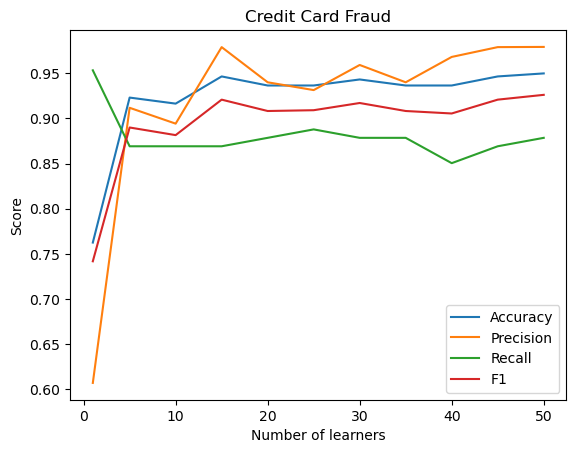

Learners: 1 --> TrinAcc:0.73 TestAcc: 0.76, Precision: 0.61, Recall: 0.95, F1: 0.74
Learners: 5 --> TrinAcc:0.93 TestAcc: 0.92, Precision: 0.91, Recall: 0.87, F1: 0.89
Learners: 10 --> TrinAcc:0.93 TestAcc: 0.92, Precision: 0.89, Recall: 0.87, F1: 0.88
Learners: 15 --> TrinAcc:0.95 TestAcc: 0.95, Precision: 0.98, Recall: 0.87, F1: 0.92
Learners: 20 --> TrinAcc:0.95 TestAcc: 0.94, Precision: 0.94, Recall: 0.88, F1: 0.91
Learners: 25 --> TrinAcc:0.95 TestAcc: 0.94, Precision: 0.93, Recall: 0.89, F1: 0.91
Learners: 30 --> TrinAcc:0.95 TestAcc: 0.94, Precision: 0.96, Recall: 0.88, F1: 0.92
Learners: 35 --> TrinAcc:0.95 TestAcc: 0.94, Precision: 0.94, Recall: 0.88, F1: 0.91
Learners: 40 --> TrinAcc:0.95 TestAcc: 0.94, Precision: 0.97, Recall: 0.85, F1: 0.91
Learners: 45 --> TrinAcc:0.96 TestAcc: 0.95, Precision: 0.98, Recall: 0.87, F1: 0.92
Learners: 50 --> TrinAcc:0.95 TestAcc: 0.95, Precision: 0.98, Recall: 0.88, F1: 0.93
--------------------------------------
Test set metrics for Logisti

In [10]:
X_train, y_train, X_test, y_test = preprocess_dataset3(data3_path)
run_adaboost_analysis(X_train, y_train, X_test, y_test, 'Credit Card Fraud')
print('--------------------------------------')
J_hist = only_logistic(X_train, y_train, X_test, y_test)

Categorical columns: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]
Numerical columns: [0, 1, 2, 3, 4, 5]


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


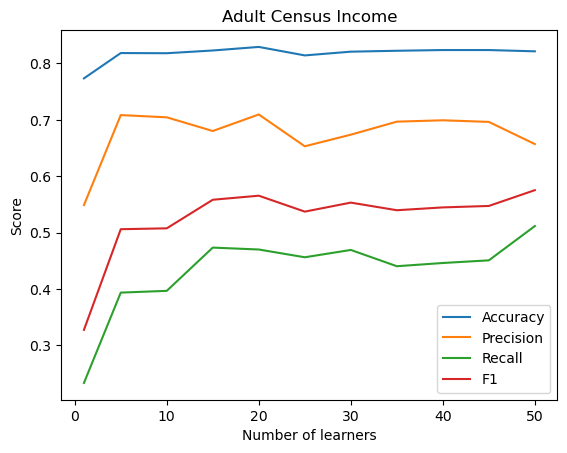

Learners: 1 --> TrinAcc:0.77 TestAcc: 0.77, Precision: 0.55, Recall: 0.23, F1: 0.33
Learners: 5 --> TrinAcc:0.82 TestAcc: 0.82, Precision: 0.71, Recall: 0.39, F1: 0.51
Learners: 10 --> TrinAcc:0.82 TestAcc: 0.82, Precision: 0.70, Recall: 0.40, F1: 0.51
Learners: 15 --> TrinAcc:0.82 TestAcc: 0.82, Precision: 0.68, Recall: 0.47, F1: 0.56
Learners: 20 --> TrinAcc:0.83 TestAcc: 0.83, Precision: 0.71, Recall: 0.47, F1: 0.57
Learners: 25 --> TrinAcc:0.81 TestAcc: 0.81, Precision: 0.65, Recall: 0.46, F1: 0.54
Learners: 30 --> TrinAcc:0.82 TestAcc: 0.82, Precision: 0.67, Recall: 0.47, F1: 0.55
Learners: 35 --> TrinAcc:0.82 TestAcc: 0.82, Precision: 0.70, Recall: 0.44, F1: 0.54
Learners: 40 --> TrinAcc:0.82 TestAcc: 0.82, Precision: 0.70, Recall: 0.45, F1: 0.54
Learners: 45 --> TrinAcc:0.82 TestAcc: 0.82, Precision: 0.70, Recall: 0.45, F1: 0.55
Learners: 50 --> TrinAcc:0.82 TestAcc: 0.82, Precision: 0.66, Recall: 0.51, F1: 0.58
-----------------------------------------
Test set metrics for Logi

In [11]:
X_train, y_train, X_test, y_test = preprocess_dataset2(data2_path, data2_extra)

selected = feature_selection(X_train, y_train, 50)
X_train = X_train[selected]
X_test = X_test[selected]

run_adaboost_analysis(X_train, y_train, X_test, y_test, 'Adult Census Income')
print('-----------------------------------------')
J_hist=only_logistic(X_train, y_train, X_test, y_test)


In [12]:
X_train, y_train, X_test, y_test = preprocess_dataset1(data1_path)


100%|██████████| 50/50 [07:08<00:00,  8.57s/it]


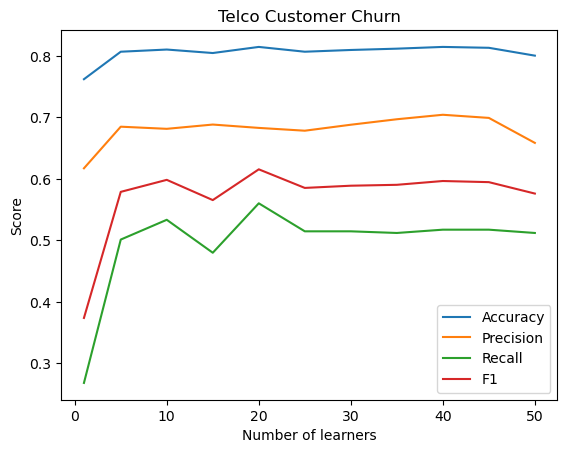

Learners: 1 --> TrinAcc:0.75 TestAcc: 0.76, Precision: 0.62, Recall: 0.27, F1: 0.37
Learners: 5 --> TrinAcc:0.79 TestAcc: 0.81, Precision: 0.68, Recall: 0.50, F1: 0.58
Learners: 10 --> TrinAcc:0.80 TestAcc: 0.81, Precision: 0.68, Recall: 0.53, F1: 0.60
Learners: 15 --> TrinAcc:0.79 TestAcc: 0.80, Precision: 0.69, Recall: 0.48, F1: 0.57
Learners: 20 --> TrinAcc:0.80 TestAcc: 0.81, Precision: 0.68, Recall: 0.56, F1: 0.62
Learners: 25 --> TrinAcc:0.80 TestAcc: 0.81, Precision: 0.68, Recall: 0.51, F1: 0.59
Learners: 30 --> TrinAcc:0.80 TestAcc: 0.81, Precision: 0.69, Recall: 0.51, F1: 0.59
Learners: 35 --> TrinAcc:0.80 TestAcc: 0.81, Precision: 0.70, Recall: 0.51, F1: 0.59
Learners: 40 --> TrinAcc:0.80 TestAcc: 0.81, Precision: 0.70, Recall: 0.52, F1: 0.60
Learners: 45 --> TrinAcc:0.79 TestAcc: 0.81, Precision: 0.70, Recall: 0.52, F1: 0.59
Learners: 50 --> TrinAcc:0.79 TestAcc: 0.80, Precision: 0.66, Recall: 0.51, F1: 0.58


In [13]:
run_adaboost_analysis(X_train, y_train, X_test, y_test, 'Telco Customer Churn')


In [14]:
print('-----------------------------------------')
J_hist = only_logistic(X_train, y_train, X_test, y_test)

-----------------------------------------
Test set metrics for Logistic Regression:
Accuracy: 0.82, Recall: 0.60, Specificity: 0.90, Precision: 0.69, FDR: 0.31, F1: 0.64
Train set metrics for Logistic Regression:
Accuracy: 0.80, Recall: 0.54, Specificity: 0.90, Precision: 0.66, FDR: 0.34, F1: 0.59
